<a href="https://colab.research.google.com/github/Sireesiru/Cryo-EM-Ultrastructures/blob/main/Bacteria_Flagella_Interaction_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install ultralytics
!pip install roboflow
!pip install opencv-python
!pip install matplotlib
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [5]:
!git clone https://github.com/Sireesiru/Cryo-EM-Ultrastructures.git

Cloning into 'Cryo-EM-Ultrastructures'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 58 (delta 6), reused 24 (delta 6), pack-reused 31 (from 2)
Receiving objects: 100% (58/58), 343.82 MiB | 58.62 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (42/42), done.


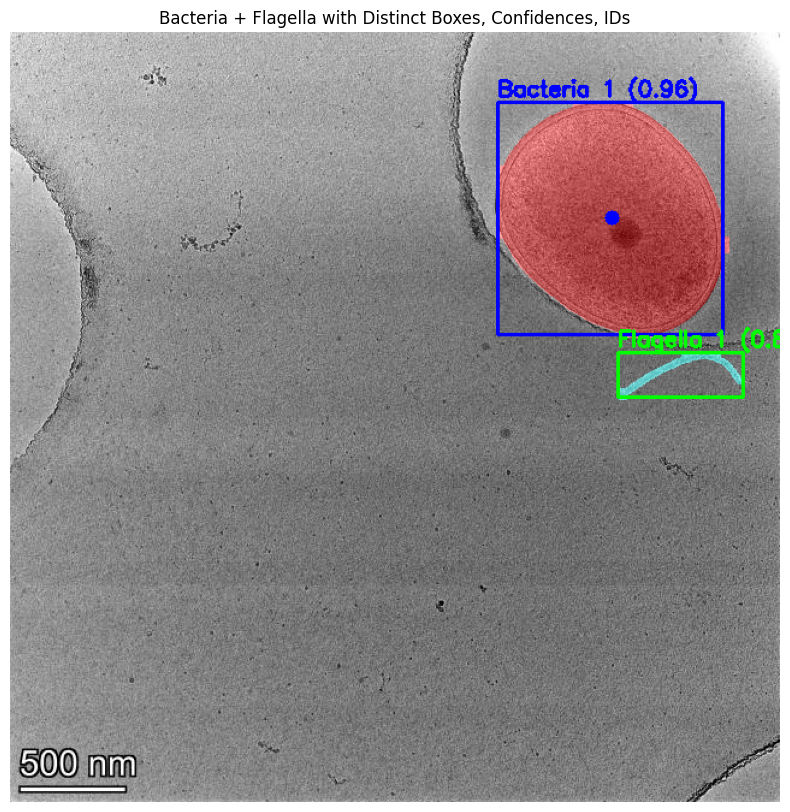

,bacterium_id,flagellum_id,bacterium_conf,flagellum_conf,flagella_length_px,flagella_length_nm,bacterium_cx,bacterium_cy,attachment_angle_deg
0,bacteria_1,flagella_1,0.957636,0.819397,104,93.4596,500,154,None


In [7]:
## Test the flagella seg medel on a test set image and get its interaction profile into a table

import os, cv2, numpy as np, pandas as pd
from ultralytics import YOLO
from skimage.measure import regionprops, label
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# ----------------------------
# Setup
# ----------------------------

model = YOLO("Cryo-EM-Ultrastructures/models/best_flagella.pt")   # segmentation model
test_image = "Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/48_Camera-Falcon-1828-Falcon_R2A_dyn_png.rf.34fee78f5e7c19178d8b0cd5a6f6def5.jpg"

nm_per_px = 0.89865

# ----------------------------
# Inference
# ----------------------------
results = model.predict(source=test_image, imgsz=640, verbose=False)
if results[0].masks is None:
    raise RuntimeError("No masks found in this image.")

image = cv2.imread(test_image)
overlay = image.copy()

# Masks + classes + boxes + confidences
masks = results[0].masks.data.cpu().numpy()
classes = results[0].boxes.cls.cpu().numpy().astype(int)
boxes = results[0].boxes.xyxy.cpu().numpy()
confs = results[0].boxes.conf.cpu().numpy()

# Resize masks to match image
masks_resized = [cv2.resize(m, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST) for m in masks]

results_list = []

# ----------------------------
# Draw masks, boxes, and labels
# ----------------------------
bact_counter, flag_counter = 1, 1

bacteria_list = []
flagella_list = []

for i, (mask, cls_id, box, conf) in enumerate(zip(masks_resized, classes, boxes, confs)):
    mask_bin = (mask > 0.5).astype(np.uint8)

    # --- 1. Overlay mask ---
    mask_rgb = np.zeros_like(image, dtype=np.uint8)
    if cls_id == 0:  # bacteria = red
        mask_rgb[mask_bin.astype(bool)] = (0, 0, 255)
        label_text = f"Bacteria {bact_counter} ({conf:.2f})"
        color_box = (255, 0, 0)  # blue
        bacteria_list.append((bact_counter, mask_bin, conf))
        bact_counter += 1
    else:  # flagella = cyan
        mask_rgb[mask_bin.astype(bool)] = (255, 255, 0)
        label_text = f"Flagella {flag_counter} ({conf:.2f})"
        color_box = (0, 255, 0)  # green
        flagella_list.append((flag_counter, mask_bin, conf))
        flag_counter += 1

    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # --- 2. Draw bounding box ---
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(overlay, (x1, y1), (x2, y2), color_box, 2)
    cv2.putText(overlay, label_text, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_box, 2)

# ----------------------------
# Bacteria + flagella analysis
# ----------------------------
for b_id, bmask_bin, b_conf in bacteria_list:
    # Centroid
    labeled = label(bmask_bin)
    props = regionprops(labeled)
    if not props:
        continue
    cy, cx = props[0].centroid
    cx, cy = int(cx), int(cy)
    cv2.circle(overlay, (cx, cy), 6, (255, 0, 0), -1)  # blue centroid

    for f_id, fmask_bin, f_conf in flagella_list:
        # --- Flagella length ---
        skel = skeletonize(fmask_bin > 0)
        length_px = np.sum(skel)
        length_nm = length_px * nm_per_px

        # --- Attachment point ---
        dilated_b = cv2.dilate(bmask_bin, np.ones((3,3), np.uint8), iterations=1)
        contact = cv2.bitwise_and(fmask_bin, dilated_b)
        yx = np.argwhere(contact > 0)

        if len(yx) > 0:
            y, x = np.mean(yx, axis=0)
            angle = np.degrees(np.arctan2(y - cy, x - cx)) % 360
            pt_contact = (int(x), int(y))
            cv2.line(overlay, (cx, cy), pt_contact, (0, 255, 255), 2)  # yellow line
        else:
            angle = None

        results_list.append([
            f"bacteria_{b_id}", f"flagella_{f_id}",
            b_conf, f_conf,
            length_px, length_nm, cx, cy, angle
        ])

# ----------------------------
# Show overlay
# ----------------------------
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Bacteria + Flagella with Distinct Boxes, Confidences, IDs")
plt.axis("off")
plt.show()

# ----------------------------
# Save results to DataFrame
# ----------------------------
df = pd.DataFrame(results_list, columns=[
    "bacterium_id", "flagellum_id",
    "bacterium_conf", "flagellum_conf",
    "flagella_length_px", "flagella_length_nm",
    "bacterium_cx", "bacterium_cy", "attachment_angle_deg"
])
display(df)

In [8]:
########## REPEAT FLAGELLA LENGHT AND ALL ABOVE FOR ALL BACTERIA IN THE TEST FOLDER
import os, cv2, numpy as np, pandas as pd
from ultralytics import YOLO
from skimage.measure import regionprops, label
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# ----------------------------
# Setup
# ----------------------------
model = YOLO("Cryo-EM-Ultrastructures/models/best_flagella.pt")
test_images_dir = "Cryo-EM-Ultrastructures/Datasets/Flagella Interaction"


# output folder
output_dir = os.path.join(test_images_dir, "predicted_results_with_coil_test_set")
os.makedirs(output_dir, exist_ok=True)

nm_per_px = 0.89865

all_results = []

# ----------------------------
# Helper: get endpoints of skeleton
# ----------------------------
def get_endpoints(skel):
    """Return endpoints of a skeletonized mask."""
    coords = np.argwhere(skel > 0)
    tips = []
    for y, x in coords:
        neighbors = skel[y-1:y+2, x-1:x+2].sum() - skel[y, x]
        if neighbors == 1:  # endpoint pixel
            tips.append((x, y))
    return tips

# ----------------------------
# Loop over all images
# ----------------------------
for image_filename in os.listdir(test_images_dir):
    if not image_filename.lower().endswith((".jpg", ".png", ".jpeg", ".tif")):
        continue

    image_path = os.path.join(test_images_dir, image_filename)
    image = cv2.imread(image_path)
    overlay = image.copy()

    # Run inference
    results = model.predict(source=image_path, verbose=False, conf=0.40)
    if results[0].masks is None:
        print(f"[!] No masks found in {image_filename}")
        continue

    masks = results[0].masks.data.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy().astype(int)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confs = results[0].boxes.conf.cpu().numpy()

    # Resize masks to match image
    masks_resized = [cv2.resize(m, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST) for m in masks]

    bact_counter, flag_counter = 1, 1
    bacteria_list, flagella_list = [], []

    # --- Draw masks + boxes + labels (unchanged style) ---
    for i, (mask, cls_id, box, conf) in enumerate(zip(masks_resized, classes, boxes, confs)):
        mask_bin = (mask > 0.5).astype(np.uint8)

        mask_rgb = np.zeros_like(image, dtype=np.uint8)
        if cls_id == 0:  # bacteria
            mask_rgb[mask_bin.astype(bool)] = (0, 0, 255)  # red
            label_text = f"Bacteria {bact_counter} ({conf:.2f})"
            color_box = (255, 0, 0)  # blue
            bacteria_list.append((bact_counter, mask_bin, conf))
            bact_counter += 1
        else:  # flagella
            mask_rgb[mask_bin.astype(bool)] = (255, 255, 0)  # cyan
            label_text = f"Flagella {flag_counter} ({conf:.2f})"
            color_box = (0, 255, 0)  # green
            flagella_list.append((flag_counter, mask_bin, conf))
            flag_counter += 1

        overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color_box, 2)
        cv2.putText(overlay, label_text, (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_box, 2)

    # --- Analysis ---
    for b_id, bmask_bin, b_conf in bacteria_list:
        labeled = label(bmask_bin)
        props = regionprops(labeled)
        if not props:
            continue
        cy, cx = props[0].centroid
        cx, cy = int(cx), int(cy)
        cv2.circle(overlay, (cx, cy), 6, (255, 0, 0), -1)  # centroid

        for f_id, fmask_bin, f_conf in flagella_list:
            # Skeleton length (blue length)
            skel = skeletonize(fmask_bin > 0)
            length_px = np.sum(skel)
            length_nm = length_px * nm_per_px

            # Tip-to-tip (red length) + coil
            tips = get_endpoints(skel)
            if len(tips) == 2:
                (x1, y1), (x2, y2) = tips
                red_length_px = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                red_length_nm = red_length_px * nm_per_px
                coil_degree = length_nm / red_length_nm

                # QC markers (two red dots + connecting line)
                cv2.circle(overlay, (x1, y1), 5, (0, 0, 255), -1)
                cv2.circle(overlay, (x2, y2), 5, (0, 0, 255), -1)
                cv2.line(overlay, (x1, y1), (x2, y2), (0, 0, 255), 2)
            else:
                red_length_nm = np.nan
                coil_degree = np.nan

            # Attachment angle
            dilated_b = cv2.dilate(bmask_bin, np.ones((3,3), np.uint8), iterations=1)
            contact = cv2.bitwise_and(fmask_bin, dilated_b)
            yx = np.argwhere(contact > 0)
            if len(yx) > 0:
                y, x = np.mean(yx, axis=0)
                angle = np.degrees(np.arctan2(y - cy, x - cx)) % 360
                pt_contact = (int(x), int(y))
                cv2.line(overlay, (cx, cy), pt_contact, (0, 255, 255), 2)
            else:
                angle = None

            # Save results row
            all_results.append([
                image_filename,
                f"bacteria_{b_id}", f"flagella_{f_id}",
                b_conf, f_conf,
                length_px, length_nm,
                red_length_nm, coil_degree,
                cx, cy, angle
            ])

    # --- Save overlay ---
    save_path = os.path.join(output_dir, f"overlay_{image_filename}")
    cv2.imwrite(save_path, overlay)
    print(f"[✓] Saved overlay with QC tips: {save_path}")

# ----------------------------
# Save results CSV
# ----------------------------
df = pd.DataFrame(all_results, columns=[
    "image", "bacterium_id", "flagellum_id",
    "bacterium_conf", "flagellum_conf",
    "flagella_length_px", "flagella_length_nm(BLUE_LENGHT)",
    "red_length_nm", "coil_degree",   # NEW
    "bacterium_cx", "bacterium_cy", "attachment_angle_deg"
])
csv_path = os.path.join(output_dir, "flagella_bacteria_test_set.csv")
df.to_csv(csv_path, index=False)
print(f"✅ Saved results CSV with coil degree: {csv_path}")

[✓] Saved overlay with QC tips: Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/overlay_106_Camera-Falcon-2326-Falcon_MOPSsuc_dyn_png.rf.9df5bc6ed8f81e0ecfb92c0e229e0a98.jpg
[✓] Saved overlay with QC tips: Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/overlay_Camera-Falcon-0102-Falcon_dyn_png.rf.a68572633173c0241178cbdc830e2f9d.jpg
[✓] Saved overlay with QC tips: Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/overlay_108_Camera-Falcon-0005-0001-Falcon_MOPSsuc_dyn_png.rf.fb1a4e464edc8d0f00d7054446bb0e62.jpg
[✓] Saved overlay with QC tips: Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/overlay_59_Camera-Falcon-2320-Falcon_MOPSsuc_dyn_png.rf.8dac3c418f6538996208cc2e75174cc9.jpg
[✓] Saved overlay with QC tips: Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/overlay_48_Camera

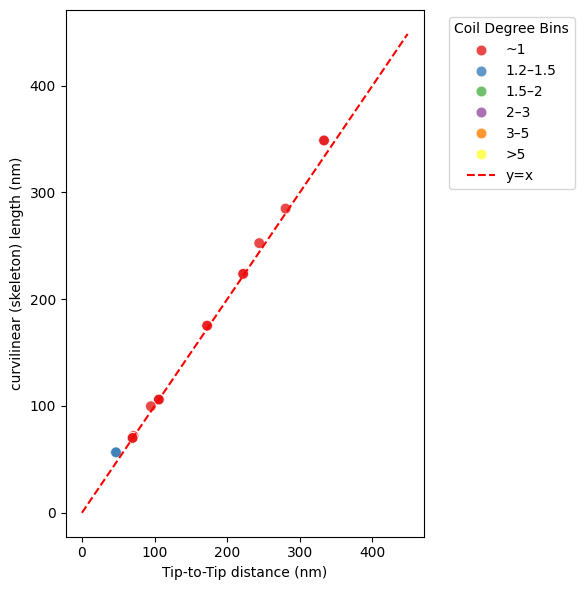

In [11]:
#Plot the degree of coiling

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = "Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/flagella_bacteria_test_set.csv"
df = pd.read_csv(csv_path)

# Define bins and labels
bins = [1, 1.2, 1.5, 2, 3, 5, 10]
labels = ["~1", "1.2–1.5", "1.5–2", "2–3", "3–5", ">5"]

# Create categorical bins
df["coil_degree_binned"] = pd.cut(
    df["coil_degree"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=df,
    x="red_length_nm",
    y="flagella_length_nm(BLUE_LENGHT)",
    hue="coil_degree_binned",   # now exists!
    palette="Set1",             # distinct colors
    alpha=0.8,
    s=60
)

plt.xlabel("Tip-to-Tip distance (nm)")
plt.ylabel("curvilinear (skeleton) length (nm)")
#plt.title("Curved vs Straight lLength QC (Binned coil degrees)")
plt.plot([0, df["flagella_length_nm(BLUE_LENGHT)"].max()],
         [0, df["flagella_length_nm(BLUE_LENGHT)"].max()],
         "r--", label="y=x")

plt.legend(title="Coil Degree Bins", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Create the directory if it doesn't exist
output_plot_dir = "/content/Cryo-EM-Ultrastructures/Datasets/Flagella Interaction/predicted_results_with_coil_test_set/plots"
os.makedirs(output_plot_dir, exist_ok=True)

#plt.savefig("/home/cloud/Flagella-bacteria-proximity-20/test/images/predicted_results_with_coil_test_set/plots/blue_vs_red_scatter.png", dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_plot_dir, "blue_vs_red_scatter.png"), dpi=300, bbox_inches="tight")
plt.show()